gofasta vs amanual mutation calling

In [4]:
import os
import re
import pandas as pd
import numpy as np
from Bio import SeqIO
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", None)

In [4]:
sc2_mm_dir = "/home/yutianc/bjorn_rep/output/SC2/escape_all"
hu1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_Hu1/'
ba1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.1_escape/'
ba2_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.2_escape/'


pb2_old_dir = '/home/yutianc/bjorn_rep/data/PB2-DMS/'
pb2_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_PP/'
pb2_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'
cy_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_CY/'
cy_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'

sc2_escape_dir = '/home/yutianc/bjorn_rep/output/SC2/escape_all/'
ba275_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.2.75/'
ba45_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.4_BA.5/'
xbb_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_XBB.1.5/'
jn1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_JN.1/'
kp2_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_KP.2/'
kp3_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_KP.3/'


In [5]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [6]:
def process(path, common_set):
    df = pd.read_csv(path, sep="\t")
    if common_set:
        df_filtered = df.copy()
        df_filtered["sra"] = df_filtered["sra"].apply(lambda x: x.split('/')[2] if len(x.split('/')) == 4 else x)
        df_filtered = df_filtered.loc[(df_filtered["sra"].isin(common_set)), :]

        return df, df_filtered
    else:
        return df, None

In [7]:
def corr_plt_nuc(standard_df, manual_df, title):
    standard, manual = standard_df.copy(), manual_df.copy()
    standard_grp = (
        standard[~standard["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual_grp = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged['pos_count_manual'], merged['pos_count_standard'], color='lightblue')
    minv = min(merged['pos_count_manual'])
    maxv = max(merged['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Nuc Comparision - {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged[merged['pos_count_standard'] != merged['pos_count_manual']]
    pos_mismatch = pos_mismatch.copy()
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)

    return pos_mismatch

In [8]:
def corr_plt_aa(standard_df, manual_df, title):
    standard, manual = standard_df.copy(), manual_df.copy()
    standard_grp = (
        standard[(~standard["alt"].str.upper().isin(ambiguous_nuc)) & ((~standard["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual.loc[(manual["ref_aa"] == "X") | (manual["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = None
    manual_grp = (
        manual[(~manual["alt"].str.upper().isin(ambiguous_nuc)) & ((~manual["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged['pos_count_manual'], merged['pos_count_standard'], color='lightblue')
    minv = min(merged['pos_count_manual'])
    maxv = max(merged['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"AA Comparision {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged[merged['pos_count_standard'] != merged['pos_count_manual']]
    pos_mismatch = pos_mismatch.copy()
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)
    
    return pos_mismatch


In [9]:
def get_common_seqs(fa1, fa2):
    seq1 = {(rec.id).split('/')[2] if len(rec.id.split('/')) == 4 else rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa1, "fasta")}
    seq2 = {(rec.id).split('/')[2] if len(rec.id.split('/')) == 4 else rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa2, "fasta")}
    common_ids = set(seq1.keys()) & set(seq2.keys())
    
    return [i for i in common_ids if seq1[i] == seq2[i]]

In [10]:
# A is standard mutation, B is manual mutation
def compare(dir_a, dir_b, id):
    print(id)
    
    common_set = get_common_seqs(os.path.join(dir_a, "alignment.fasta"), os.path.join(dir_b, "alignment.fasta"))
    mut_a, mut_a_filtered = process(os.path.join(dir_a, "mutations.tsv"), common_set)
    mut_b, mut_b_filtered = process(os.path.join(dir_b, "mutations.tsv"), common_set)
    mut_b_filtered = mut_b_filtered[mut_b_filtered['region'] == id]

    print(round(len(mut_a_filtered)/len(mut_a), 2)*100, "% identical in alignment.")
    pos_mismatch = corr_plt_nuc(mut_a_filtered, mut_b_filtered, id)
    print(pos_mismatch)
    pos_mismatch = corr_plt_aa(mut_a_filtered, mut_b_filtered, id)
    print(pos_mismatch)

    tmp1 = (mut_a_filtered[~mut_a_filtered["alt"].isin(ambiguous_nuc)]
            .drop(columns=["ref_codon", "alt_codon"])
            .sort_values(by=["sra", "pos", "GFF_FEATURE"])
            .reset_index(drop=True)
    )

    mut_b_filtered = mut_b_filtered.drop(columns=["ref_codon", "alt_codon"])

    tmp2_a = mut_b_filtered[mut_b_filtered["alt_aa"] == "X"]
    tmp2_b = mut_b_filtered[mut_b_filtered["alt_aa"] != "X"]

    tmp2_a.loc[(tmp2_a["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = None    
    tmp2_a = tmp2_a.drop_duplicates()
    tmp2_a = tmp2_a[~tmp2_a["alt"].isin(ambiguous_nuc)]

    tmp2_b = tmp2_b[~tmp2_b["alt"].isin(ambiguous_nuc)]

    tmp2 = pd.concat([tmp2_a, tmp2_b], ignore_index=True)
    tmp2 = tmp2.sort_values(by=["sra", "pos", "GFF_FEATURE"]).reset_index(drop=True)

    print(len(tmp1))
    print(len(tmp2))    

    try:
        tmp1.compare(tmp2, keep_equal=True)
    except:
        print("Somthing wrong...")

    return mut_a_filtered, mut_b_filtered, tmp1, tmp2






## Hu1, BA.1, and BA.2


NC_045512.2
100.0 % identical in alignment.


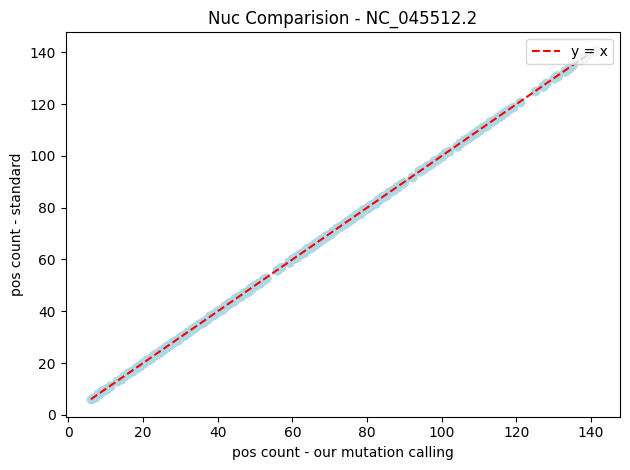

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


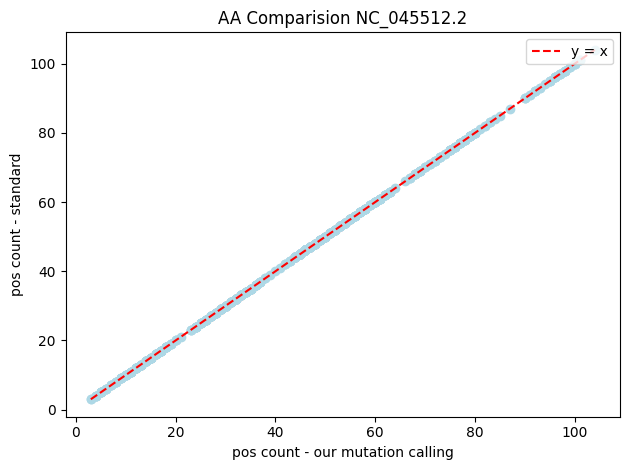

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
68031
68031


In [11]:
mut_a, mut_b, tmp1, tmp2 = compare(hu1_gf_dir, sc2_mm_dir, "NC_045512.2")

NC_045512.2_escape_BA.1_rbd
100.0 % identical in alignment.


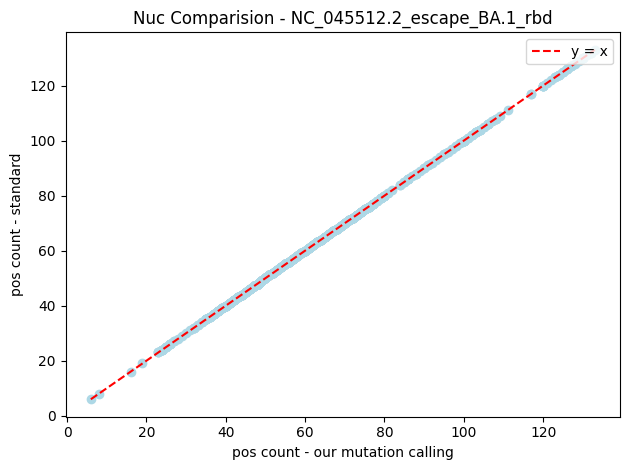

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


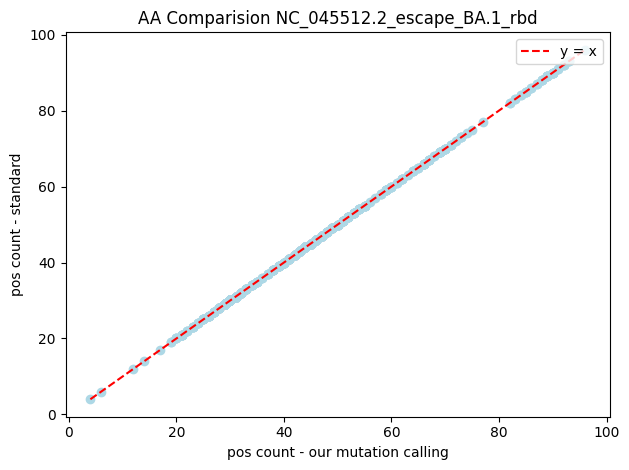

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67910
67910


In [12]:
mut_a, mut_b, tmp1, tmp2 = compare(ba1_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.1_rbd")

NC_045512.2_escape_BA.2_rbd
100.0 % identical in alignment.


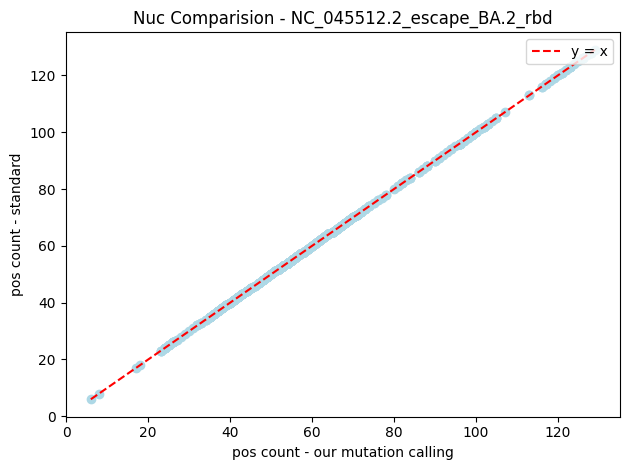

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


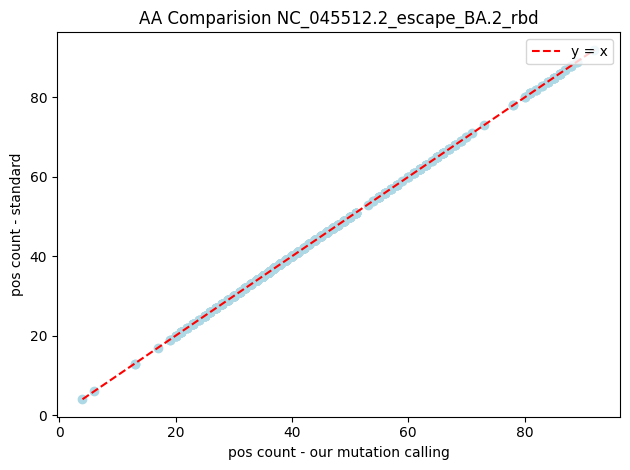

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67348
67348


In [13]:
mut_a, mut_b, tmp1, tmp2 = compare(ba2_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.2_rbd")

NC_045512.2_escape_BA.2.75_rbd
100.0 % identical in alignment.


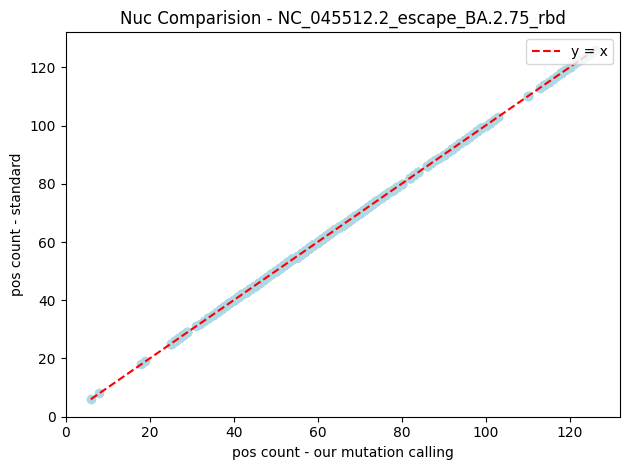

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


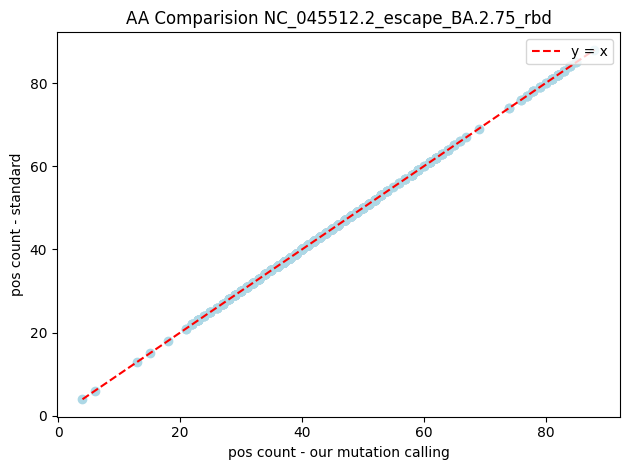

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
68715
68715


In [14]:
mut_a, mut_b, tmp1, tmp2 = compare(ba275_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.2.75_rbd")

NC_045512.2_escape_BA.4_BA.5_rbd
100.0 % identical in alignment.


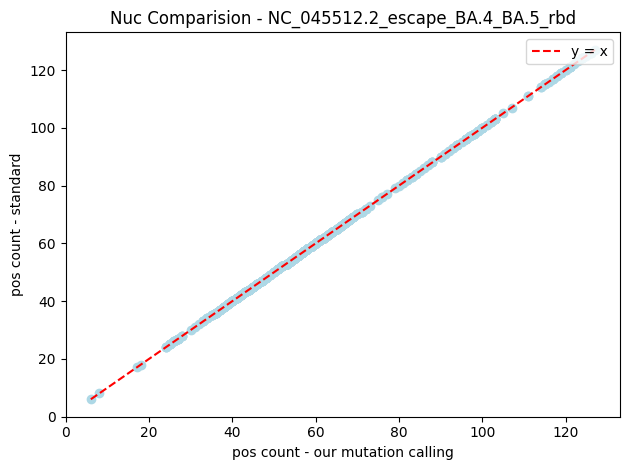

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


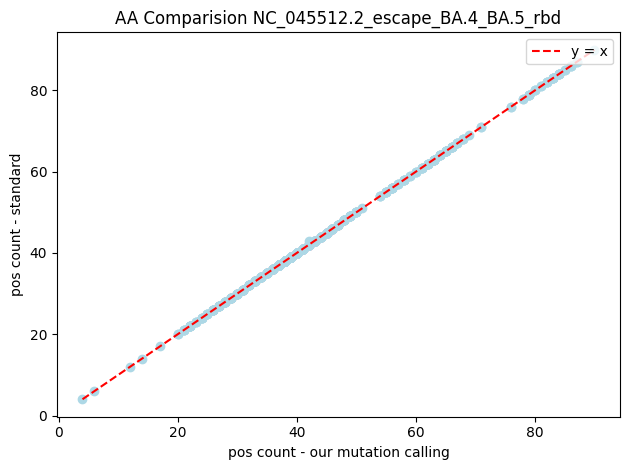

               sra  pos_count_standard  pos_count_manual  gap
666  SEARCH-102460                  43                42   -1
67455
67455


In [15]:
mut_a, mut_b, tmp1, tmp2 = compare(ba45_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.4_BA.5_rbd")

NC_045512.2_escape_XBB.1.5_rbd
100.0 % identical in alignment.


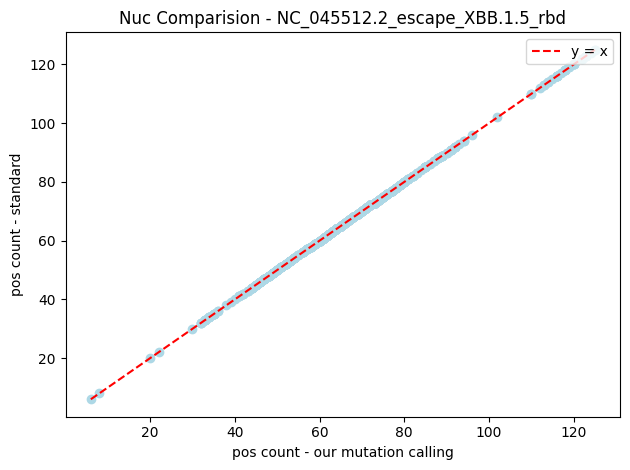

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


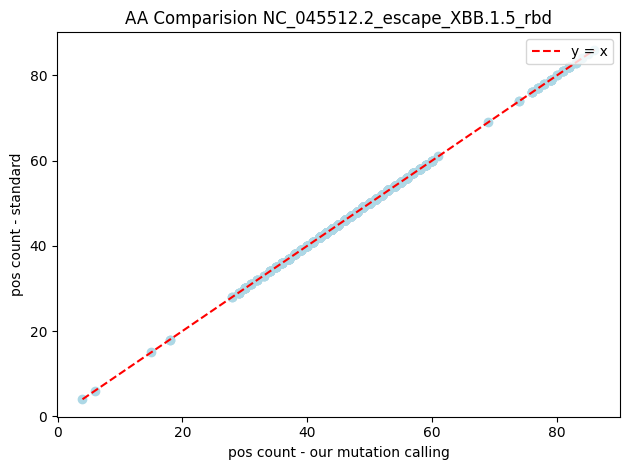

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
73762
73762


In [16]:
mut_a, mut_b, tmp1, tmp2 = compare(xbb_gf_dir, sc2_mm_dir, "NC_045512.2_escape_XBB.1.5_rbd")

NC_045512.2_escape_JN.1_rbd
94.0 % identical in alignment.


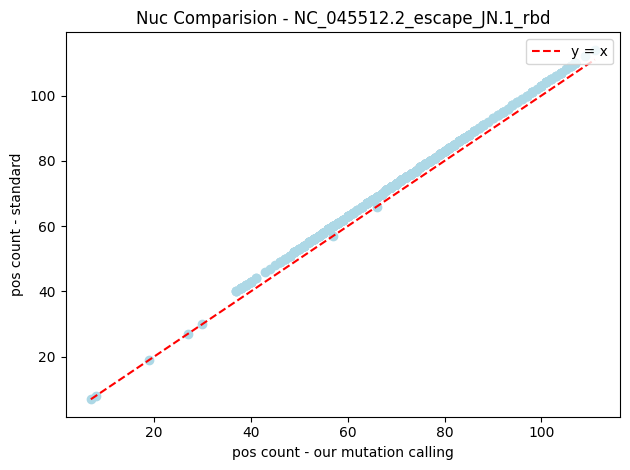

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  82                79   -3
0             ALSR-1584                  41                38   -3
1             ALSR-1678                  40                37   -3
2         ATM-H48RA4QQ6                  76                73   -3
3         ATM-Q4EEY2D3N                  68                65   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  70                67   -3
26   CA-SDCPHL-91021350                  66                63   -3
27     CA-SEARCH-103136                  70                67   -3
28     CA-SEARCH-103152                  56                53   -3
29     CA-SEARCH-103471                  53                50   -3

[950 rows x 4 columns]


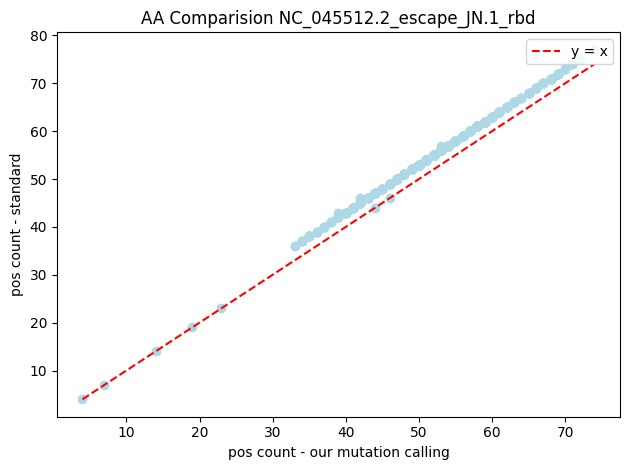

                  sra  pos_count_standard  pos_count_manual  gap
956     STM-ZMR4VFTFK                  55                52   -3
0           ALSR-1584                  37                34   -3
1           ALSR-1678                  38                35   -3
2       ATM-H48RA4QQ6                  60                57   -3
3       ATM-Q4EEY2D3N                  56                53   -3
..                ...                 ...               ...  ...
28   CA-SEARCH-103152                  46                43   -3
29   CA-SEARCH-103471                  45                42   -3
35   CA-SEARCH-103879                  46                42   -4
674      SEARCH-15574                  43                39   -4
628     SEARCH-102460                  57                53   -4

[950 rows x 4 columns]
77101
74251
Somthing wrong...


In [17]:
# there should be mismatch here since I manually modify nucs in reference genome to make it compatibale with gofasta
mut_a, mut_b, tmp1, tmp2 = compare(jn1_gf_dir, sc2_mm_dir, "NC_045512.2_escape_JN.1_rbd")

NC_045512.2_escape_KP.2_rbd
94.0 % identical in alignment.


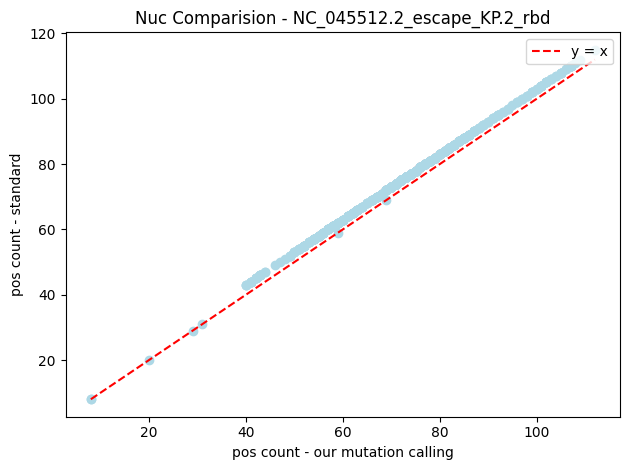

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  85                82   -3
0             ALSR-1584                  44                41   -3
1             ALSR-1678                  43                40   -3
2         ATM-H48RA4QQ6                  79                76   -3
3         ATM-Q4EEY2D3N                  71                68   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  73                70   -3
26   CA-SDCPHL-91021350                  69                66   -3
27     CA-SEARCH-103136                  73                70   -3
28     CA-SEARCH-103152                  59                56   -3
29     CA-SEARCH-103471                  56                53   -3

[950 rows x 4 columns]


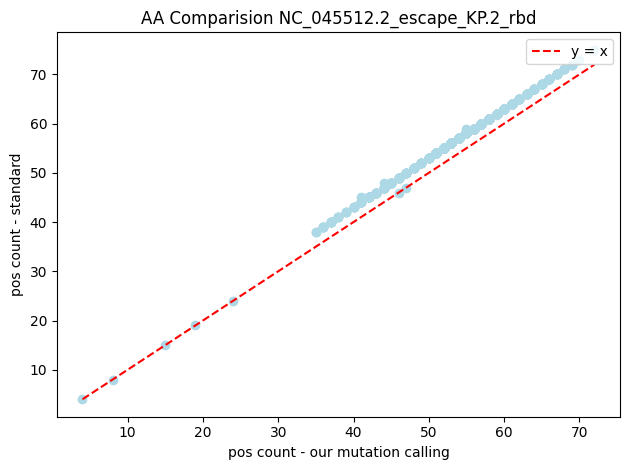

                  sra  pos_count_standard  pos_count_manual  gap
956     STM-ZMR4VFTFK                  57                54   -3
0           ALSR-1584                  39                36   -3
1           ALSR-1678                  40                37   -3
2       ATM-H48RA4QQ6                  62                59   -3
3       ATM-Q4EEY2D3N                  58                55   -3
..                ...                 ...               ...  ...
28   CA-SEARCH-103152                  48                45   -3
29   CA-SEARCH-103471                  47                44   -3
35   CA-SEARCH-103879                  48                44   -4
674      SEARCH-15574                  45                41   -4
628     SEARCH-102460                  59                55   -4

[950 rows x 4 columns]
79431
76581
Somthing wrong...


In [18]:
# there should be mismatch here since I manually modify nucs in reference genome to make it compatibale with gofasta
mut_a, mut_b, tmp1, tmp2 = compare(kp2_gf_dir, sc2_mm_dir, "NC_045512.2_escape_KP.2_rbd")

NC_045512.2_escape_KP.3_rbd
94.0 % identical in alignment.


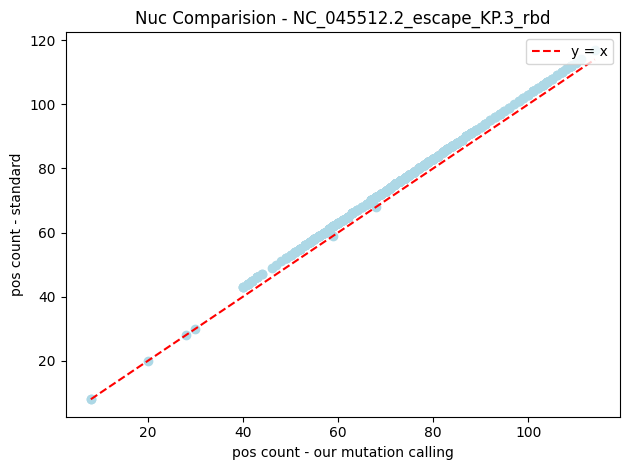

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  85                82   -3
0             ALSR-1584                  44                41   -3
1             ALSR-1678                  43                40   -3
2         ATM-H48RA4QQ6                  79                76   -3
3         ATM-Q4EEY2D3N                  71                68   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  73                70   -3
26   CA-SDCPHL-91021350                  69                66   -3
27     CA-SEARCH-103136                  73                70   -3
28     CA-SEARCH-103152                  59                56   -3
29     CA-SEARCH-103471                  56                53   -3

[950 rows x 4 columns]


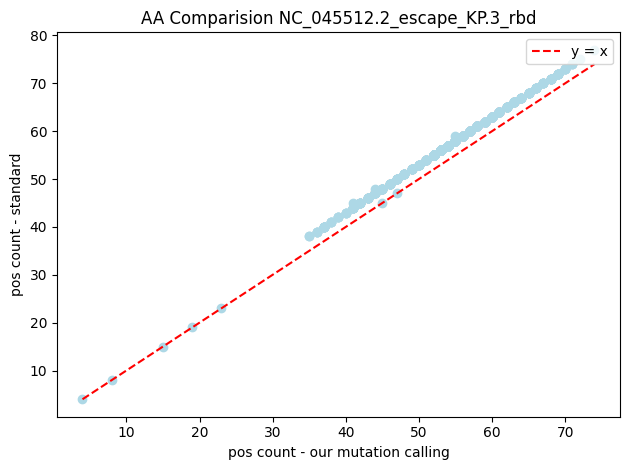

                  sra  pos_count_standard  pos_count_manual  gap
956     STM-ZMR4VFTFK                  57                54   -3
0           ALSR-1584                  39                36   -3
1           ALSR-1678                  40                37   -3
2       ATM-H48RA4QQ6                  62                59   -3
3       ATM-Q4EEY2D3N                  58                55   -3
..                ...                 ...               ...  ...
28   CA-SEARCH-103152                  48                45   -3
29   CA-SEARCH-103471                  47                44   -3
35   CA-SEARCH-103879                  48                44   -4
674      SEARCH-15574                  45                41   -4
628     SEARCH-102460                  59                55   -4

[950 rows x 4 columns]
79829
76979
Somthing wrong...


In [19]:
# there should be mismatch here since I manually modify nucs in reference genome to make it compatibale with gofasta
mut_a, mut_b, tmp1, tmp2 = compare(kp3_gf_dir, sc2_mm_dir, "NC_045512.2_escape_KP.3_rbd")

In [ ]:
# calculate prevalence
# For a given lineage, its the number of samples that have a particular mutation at a site out of all the samples that belong to that lineage

# SQL query to export the prevalence from muninn

'''
\copy (
    WITH denom AS (
    SELECT
        sl.lineage_id,
        l.lineage_name,
        COUNT(DISTINCT sl.sample_id) AS n_in_lineage
    FROM samples_lineages sl
    JOIN lineages l ON sl.lineage_id = l.id
    JOIN samples s ON s.id = sl.sample_id
    JOIN mutations m ON m.sample_id = s.id
    JOIN alleles a ON m.allele_id = a.id
    WHERE a.region = 'NC_045512.2'
    GROUP BY sl.lineage_id, l.lineage_name
    ORDER BY l.lineage_name
    ),
    amino_acid_sites AS (
    SELECT DISTINCT
        sl.lineage_id,
        l.lineage_name,
        (aa.ref_aa || aa.position_aa::text || aa.alt_aa) AS aa_site,
        COUNT(DISTINCT m.sample_id) AS n_mut,
        a.position_nt
    FROM amino_acids aa
    JOIN mutation_translations mt ON aa.id = mt.amino_acid_id
    JOIN mutations m ON m.id = mt.mutation_id
    JOIN alleles a ON a.id = m.allele_id
    JOIN samples_lineages sl ON m.sample_id = sl.sample_id
    JOIN lineages l ON sl.lineage_id = l.id
    WHERE a.region = 'NC_045512.2'
    GROUP BY sl.lineage_id, l.lineage_name, aa.ref_aa, aa.position_aa, aa.alt_aa, a.position_nt
    ORDER BY l.lineage_name
    )

    SELECT 
        aas.lineage_id,
        aas.lineage_name,
        aas.aa_site,
        aas.n_mut,
        d.n_in_lineage,
        aas.position_nt,
        aas.n_mut::numeric / d.n_in_lineage AS prevalence
    FROM amino_acid_sites aas
    JOIN denom d ON aas.lineage_name = d.lineage_name
) TO 'prevalence_aa.csv' WITH CSV HEADER;

'''

In [1]:
def _aa_pos(aa_site: str): 
    m = re.search(r"(\d+)", str(aa_site)) 
    return int(m.group(1)) if m else None

def aa_heatmap(aa_prevalence_path, lineage_ls, threshold, region="spike"):
    SPIKE_COORDS = [21563, 25384]
    RBD_COORDS = [22553, 23155]
    region_coords = SPIKE_COORDS if region.lower() == "spike" else RBD_COORDS

    df = pd.read_csv(aa_prevalence_path)

    # IMPORTANT: don't filter by prevalence here, or you'll create fake "missing"
    mat = (
        df[(df["lineage_name"].isin(lineage_ls))
           & (region_coords[0] <= df["position_nt"])
           & (df["position_nt"] <= region_coords[1])]
        .pivot_table(index="lineage_name", columns="aa_site", values="prevalence", aggfunc="max")
        .reindex(lineage_ls)
    )

    # Keep only AA sites where at least one lineage has prevalence > 0.5
    keep_cutoff = 0.5
    mat = mat.loc[:, (mat > keep_cutoff).any(axis=0)]

    cols_sorted = sorted(mat.columns, key=lambda s: (_aa_pos(s) if _aa_pos(s) is not None else 10**9, str(s)))
    mat = mat.reindex(columns=cols_sorted)

    data = mat.to_numpy(dtype=float)   # keep NaNs = truly missing

    # colormap with NaNs in grey (missing only)
    cmap = mpl.cm.get_cmap("RdPu").copy()
    cmap.set_bad("#BDBDBD")  # missing prevalence only

    nrows, ncols = data.shape
    fig, ax = plt.subplots(figsize=(20, 6))

    x = np.arange(ncols + 1)
    y = np.arange(nrows + 1)

    # If you want the color scale to "start" at threshold but still show <threshold,
    # use clipping so anything below threshold maps to the lowest color (not grey).
    norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)

    mesh = ax.pcolormesh(
        x, y, data,
        cmap=cmap,
        norm=norm,
        shading="flat",
        edgecolors="white",
        linewidth=0.8
    )

    # axes styling unchanged...
    ax.set_yticks(np.arange(nrows) + 0.5)
    ax.set_yticklabels(mat.index)
    ax.invert_yaxis()

    tick_pos = np.arange(ncols) + 0.5
    labels = mat.columns.astype(str).tolist()
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(labels, rotation=60, ha="center", va="top", fontsize=8)
    ax.tick_params(axis="x", pad=2)

    ax.set_xlim(0, ncols)
    ax.set_ylim(nrows, 0)

    ax.set_facecolor("white")
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    cax = fig.add_axes([0.12, 0.84, 0.55, 0.05])
    cb = fig.colorbar(mesh, cax=cax, orientation="horizontal")
    cb.set_label("val", labelpad=-28, x=-0.06, rotation=0)
    cb.set_ticks(np.linspace(threshold, 1, 6))

    missing_patch = mpl.patches.Patch(color="#BDBDBD", label="not detected")
    ax.legend(handles=[missing_patch], loc="upper left", bbox_to_anchor=(1.005, 1.02),
              frameon=False, borderaxespad=0.0)

    plt.subplots_adjust(top=0.78, bottom=0.22, left=0.18, right=0.98)

    return fig, ax, data


/tmp/ipykernel_2096082/992884397.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("RdPu").copy()


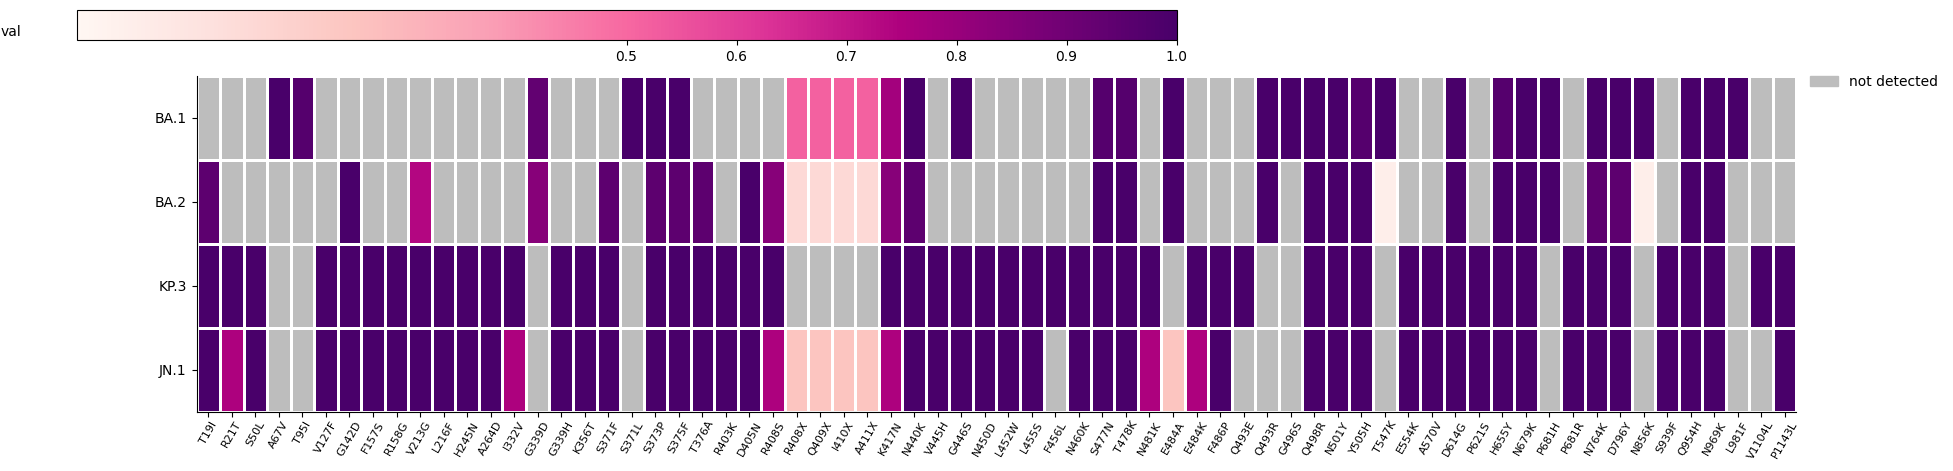

In [4]:
fig, ax, data = aa_heatmap("/home/yutianc/muninn_sc2/prevalence_aa.csv", ['BA.1', 'BA.2', 'KP.3', 'JN.1'], 0.5, "spike")

In [ ]:
## Query to get sample collection time and evescape score
'''
\copy (
    SELECT 
        s.accession, 
        s.collection_start_date, 
        s.collection_end_date, 
        pmv.value AS evescape_score, 
        (aa.ref_aa || aa.position_aa::text || aa.alt_aa) AS aa_site,
        aa.gff_feature
    FROM samples s
    JOIN mutations m ON s.id = m.sample_id
    JOIN mutation_translations mt ON m.id = mt.mutation_id
    JOIN amino_acids aa ON aa.id = mt.amino_acid_id
    JOIN phenotype_metric_values pmv ON aa.id = pmv.amino_acid_id 
    JOIN phenotype_metrics pm ON pm.id = pmv.phenotype_metric_id
    WHERE pm.name = 'evescape'
) TO 'evescape_time.csv' WITH CSV HEADER;

'''

In [ ]:
## Query to get sample collection time and dms binding and expression score

'''
\copy (
  SELECT
    s.accession,
    s.collection_start_date,
    s.collection_end_date,
    pm.name AS name,
    pmv.value,
    (aa.ref_aa || aa.position_aa::text || aa.alt_aa) AS aa_site,
    aa.gff_feature
  FROM samples s
  JOIN mutations m ON s.id = m.sample_id
  JOIN mutation_translations mt ON m.id = mt.mutation_id
  JOIN amino_acids aa ON aa.id = mt.amino_acid_id
  JOIN phenotype_metric_values pmv ON aa.id = pmv.amino_acid_id
  JOIN phenotype_metrics pm ON pm.id = pmv.phenotype_metric_id
  WHERE pm.name IN ('species_sera_escape', 'entry_in_293t_cells') 
) TO 'dms_time.csv' WITH CSV HEADER;
'''

/tmp/ipykernel_2492698/361188067.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=month_order, showfliers=False)


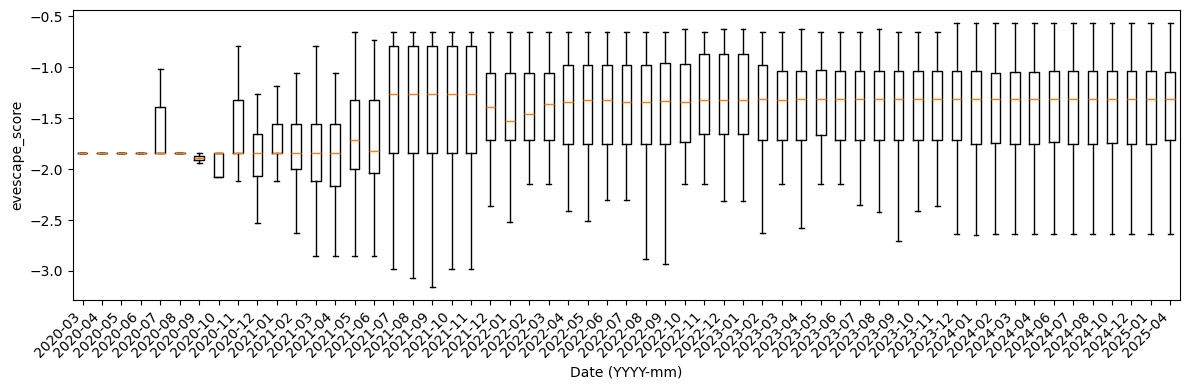

In [ ]:
evescore = pd.read_csv('/home/yutianc/muninn_sc2/evescape_time.csv')
evescore["collection_date"] = evescore["collection_start_date"].apply(lambda x: x.strip()[:7])

date_col = "collection_date"
value_col = "evescape_score"

evescore[date_col] = pd.to_datetime(evescore[date_col], errors="coerce")
evescore["yyyy_mm"] = evescore[date_col].dt.to_period("M").astype(str)

month_order = (
    evescore[[date_col, "yyyy_mm"]]
    .drop_duplicates()
    .sort_values(date_col)["yyyy_mm"]
    .unique()
)

data = [evescore.loc[evescore["yyyy_mm"] == m, value_col].astype(float).values for m in month_order]

fig, ax = plt.subplots(figsize=(12, 4))
bp = ax.boxplot(data, labels=month_order, showfliers=False)

stats = evescore.groupby("yyyy_mm")[value_col].agg(["mean", "std"]).reindex(month_order)
x = range(1, len(month_order) + 1)

ax.set_xlabel("Date (YYYY-mm)")
ax.set_ylabel(value_col)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [33]:
data[4]

array([-1.8461537, -1.8461537, -1.8461537, -1.39481  , -1.0154915])

In [60]:
# name: species_sera_escape - delta_bind, entry_in_293t_cells - delta_expr since i can't change the col names in the database
dms = pd.read_csv('/home/yutianc/muninn_sc2/dms_time.csv')
dms["collection_date"] = dms["collection_start_date"].apply(lambda x: x.strip()[:7])

dms_bind = dms[dms["name"] == 'species_sera_escape']
dms_expr = dms[dms["name"] == 'entry_in_293t_cells']


In [61]:
dms_bind.head()

,accession,collection_start_date,collection_end_date,name,value,aa_site,gff_feature,collection_date
0,CA-SEARCH-233062,2024-07-02,2024-07-02,species_sera_escape,0.09891,L371F,YP_009724390.1_NC_045512.2_escape_BA.1_rbd,2024-07
1,CA-SEARCH-233062,2024-07-02,2024-07-02,species_sera_escape,0.09891,L371F,YP_009724390.1_NC_045512.2_escape_BA.1_rbd,2024-07
2,CA-SEARCH-141628,2024-07-26,2024-07-26,species_sera_escape,0.09891,L371F,YP_009724390.1_NC_045512.2_escape_BA.1_rbd,2024-07
3,CA-SEARCH-95058,2022-06-01,2022-06-01,species_sera_escape,0.09891,L371F,YP_009724390.1_NC_045512.2_escape_BA.1_rbd,2022-06
4,CA-SEARCH-230265,2023-10-13,2023-10-13,species_sera_escape,0.09891,L371F,YP_009724390.1_NC_045512.2_escape_BA.1_rbd,2023-10


In [65]:
# date_col = "collection_date"
# value_col = "value"

# dms_expr[date_col] = pd.to_datetime(dms_expr[date_col], errors="coerce")
# dms_expr["yyyy_mm"] = dms_expr[date_col].dt.to_period("M").astype(str)

# month_order = (
#     dms_expr[[date_col, "yyyy_mm"]]
#     .drop_duplicates()
#     .sort_values(date_col)["yyyy_mm"]
#     .unique()
# )

# data = [dms_expr.loc[dms_expr["yyyy_mm"] == m, value_col].astype(float).values for m in month_order]

# fig, ax = plt.subplots(figsize=(12, 4))
# bp = ax.boxplot(data, labels=month_order, showfliers=False)

# stats = dms_expr.groupby("yyyy_mm")[value_col].agg(["mean", "std"]).reindex(month_order)
# x = range(1, len(month_order) + 1)

# ax.set_xlabel("Date (YYYY-mm)")
# ax.set_ylabel(value_col)
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()

In [66]:
# date_col = "collection_date"
# value_col = "value"

# dms_bind[date_col] = pd.to_datetime(dms_bind[date_col], errors="coerce")
# dms_bind["yyyy_mm"] = dms_bind[date_col].dt.to_period("M").astype(str)

# # ensure values are numeric (non-numeric -> NaN)
# dms_bind[value_col] = pd.to_numeric(dms_bind[value_col], errors="coerce")

# # drop rows missing date/month or value
# dms_bind = dms_bind.dropna(subset=[date_col, "yyyy_mm", value_col])

# month_order = (
#     dms_bind[[date_col, "yyyy_mm"]]
#     .drop_duplicates()
#     .sort_values(date_col)["yyyy_mm"]
#     .unique()
# )

# data = [
#     dms_bind.loc[dms_bind["yyyy_mm"] == m, value_col].to_numpy()
#     for m in month_order
# ]

# fig, ax = plt.subplots(figsize=(12, 4))
# ax.boxplot(data, labels=month_order, showfliers=False)

# # mean/std overlay if you want it
# stats = dms_bind.groupby("yyyy_mm")[value_col].agg(["mean", "std"]).reindex(month_order)
# x = range(1, len(month_order) + 1)
# ax.errorbar(x, stats["mean"], yerr=stats["std"], fmt="o")

# ax.set_xlabel("Date (YYYY-mm)")
# ax.set_ylabel(value_col)
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()
